### Libraries and Settings

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [66]:
pd.set_option('display.max_columns', None)

### Import Data

In [67]:
train = pd.read_csv('../data/Model Train.csv').drop('Unnamed: 0', axis=1)

In [68]:
test = pd.read_csv('../data/Model Test.csv').drop('Unnamed: 0', axis=1)

In [69]:
Ktest = pd.read_csv('../data/Kaggle_test.csv')

In [71]:
# features = Ktest.isnull().sum().index

# missing = []
# missing.append(train.isnull().sum()[:-1])
# missing.append(test.isnull().sum()[:-1])
# missing.append(Ktest.isnull().sum())

# missingness = pd.DataFrame({'train':missing[0],'test':missing[1],'Ktest':missing[2]},
#                            index=features)

# pd.set_option('display.max_rows', None)
# missingness
# # pd.reset_option('display.max_rows')

# Nominal Categorical Features

In [8]:
cat_nom_cols = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour',
                'Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
                'Condition2','BldgType','HouseStyle']

### MSSubClass

Modify this column to 'PUD' if the house is a PUD, and 'NotPUD' if it's not a PUD. Other infomation in this column is redundent because it's repeated in other columns.

In [9]:
def pp_MSSubClass(sr):
    sr_temp = sr.apply(lambda x: 'PUD' if x in [120,150,160,180] else 'NotPUD')
    return(sr_temp)

In [10]:
train['MSSubClass'] = pp_MSSubClass(train['MSSubClass'])
test['MSSubClass'] = pp_MSSubClass(test['MSSubClass'])
Ktest['MSSubClass'] = pp_MSSubClass(Ktest['MSSubClass'])

### Alley

NA means no alley access. So impute with 'NoAlley'.

In [19]:
def pp_Alley(sr):
    sr_temp = sr.fillna('NoAlley')
    return(sr_temp)

In [20]:
train['Alley'] = pp_Alley(train['Alley'])
test['Alley'] = pp_Alley(test['Alley'])
Ktest['Alley'] = pp_Alley(Ktest['Alley'])

### Impute

In [21]:
cat_nom_imp = SimpleImputer(strategy='most_frequent')
cat_nom_imp = cat_nom_imp.fit(train[cat_nom_cols])

In [22]:
cat_nom_imp_train = pd.DataFrame(cat_nom_imp.transform(train[cat_nom_cols]),
                                columns = cat_nom_cols)
cat_nom_imp_test = pd.DataFrame(cat_nom_imp.transform(test[cat_nom_cols]),
                                columns = cat_nom_cols)
cat_nom_imp_Ktest = pd.DataFrame(cat_nom_imp.transform(Ktest[cat_nom_cols]),
                                columns = cat_nom_cols)

### One Hot Encoding

In [23]:
drop_col = train[cat_nom_cols].apply(lambda col: col.value_counts().index[0])

cat_nom_ohe = OneHotEncoder(categories='auto', drop=drop_col, sparse = False)
cat_nom_ohe = cat_nom_ohe.fit(cat_nom_imp_train)

new_cols = cat_nom_ohe.get_feature_names(cat_nom_cols)

In [24]:
cat_nom_clean_train = pd.DataFrame(cat_nom_ohe.transform(cat_nom_imp_train),
                                   columns=new_cols )
cat_nom_clean_test = pd.DataFrame(cat_nom_ohe.transform(cat_nom_imp_test),
                                  columns=new_cols )
cat_nom_clean_Ktest = pd.DataFrame(cat_nom_ohe.transform(cat_nom_imp_Ktest),
                                   columns=new_cols )

### Condition1 & Condition2

Combine condition1 and condition2 together.

In [25]:
Condition1_cols = [col for col in new_cols if 'Condition1' in col]
Condition2_cols = [col for col in new_cols if 'Condition2' in col]
print(Condition1_cols)
print(Condition2_cols)

['Condition1_Artery', 'Condition1_Feedr', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn']
['Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn']


One feature, 'Condition1_RRNe', is not in Condition2_cols. Get rid of it from Condition1_cols.

In [26]:
Condition1_cols.remove('Condition1_RRNe')

In [27]:
def combine_C1_C2(df):
    df_temp = df.copy()
    for i in range(len(Condition1_cols)):
        mask = df_temp[Condition2_cols[i]] == 1
        df_temp.loc[mask,Condition1_cols[i]] = 1
    df_temp = df_temp.drop(Condition2_cols,axis=1)
    return(df_temp)

In [28]:
cat_nom_clean_train = combine_C1_C2(cat_nom_clean_train)
cat_nom_clean_test = combine_C1_C2(cat_nom_clean_test)
cat_nom_clean_Ktest = combine_C1_C2(cat_nom_clean_Ktest)

# Ordinal Categorical Features

In [29]:
cat_ord_cols = ['OverallQual', 'OverallCond','AgeBuilt','AgeRemodAdd']

### YearBuilt

Change this column to building age at sale.

In [30]:
train['AgeBuilt'] = train['YrSold'] - train['YearBuilt']
test['AgeBuilt'] = test['YrSold'] - test['YearBuilt']
Ktest['AgeBuilt'] = Ktest['YrSold'] - Ktest['YearBuilt']

### YearRemodAdd

Change this column to remodeling age at sale.

In [31]:
train['AgeRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
test['AgeRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
Ktest['AgeRemodAdd'] = Ktest['YrSold'] - Ktest['YearRemodAdd']

### Impute

In [32]:
cat_ord_imp = SimpleImputer(strategy='median')
cat_ord_imp = cat_ord_imp.fit(train[cat_ord_cols])

In [33]:
cat_ord_imp_train = pd.DataFrame(cat_ord_imp.transform(train[cat_ord_cols]),
                                columns = cat_ord_cols)
cat_ord_imp_test = pd.DataFrame(cat_ord_imp.transform(test[cat_ord_cols]),
                                columns = cat_ord_cols)
cat_ord_imp_Ktest = pd.DataFrame(cat_ord_imp.transform(Ktest[cat_ord_cols]),
                                columns = cat_ord_cols)

### Scale

In [34]:
cat_ord_scl = StandardScaler()
cat_ord_scl = cat_ord_scl.fit(cat_ord_imp_train)

In [35]:
cat_ord_clean_train = pd.DataFrame(cat_ord_scl.transform(cat_ord_imp_train),
                                columns = cat_ord_cols)
cat_ord_clean_test = pd.DataFrame(cat_ord_scl.transform(cat_ord_imp_test),
                                columns = cat_ord_cols)
cat_ord_clean_Ktest = pd.DataFrame(cat_ord_scl.transform(cat_ord_imp_Ktest),
                                columns = cat_ord_cols)

# Numerical Features

In [36]:
num_cols = ['LotFrontage','LotArea']

For both columns, log transform first, then scale, then impute using knn on the whole dataset.

### LotArea

In [37]:
train['LotArea'] = np.log(train['LotArea'])
test['LotArea'] = np.log(test['LotArea'])
Ktest['LotArea'] = np.log(Ktest['LotArea'])

### LotFrontage

In [38]:
train['LotFrontage'] = np.log(train['LotFrontage'])
test['LotFrontage'] = np.log(test['LotFrontage'])
Ktest['LotFrontage'] = np.log(Ktest['LotFrontage'])

### Scale

In [39]:
num_scl = StandardScaler()
num_scl = num_scl.fit(train[num_cols])

In [40]:
num_clean_train = pd.DataFrame(num_scl.transform(train[num_cols]),columns=num_cols)
num_clean_test = pd.DataFrame(num_scl.transform(test[num_cols]),columns=num_cols)
num_clean_Ktest = pd.DataFrame(num_scl.transform(Ktest[num_cols]),columns=num_cols)

# Merge Together

In [41]:
clean_train = pd.concat([cat_nom_clean_train,cat_ord_clean_train,num_clean_train],axis=1)
clean_test = pd.concat([cat_nom_clean_test,cat_ord_clean_test,num_clean_test],axis=1)
clean_Ktest = pd.concat([cat_nom_clean_Ktest,cat_ord_clean_Ktest,num_clean_Ktest],axis=1)

### Impute LotFrontage Using KNN

In [42]:
from math import sqrt
n_neighbors = round(sqrt(train.shape[0]))
num_imp = KNNImputer(n_neighbors=n_neighbors)
num_imp = num_imp.fit(clean_train)

In [43]:
cols = clean_train.columns
clean_train = pd.DataFrame(num_imp.transform(clean_train),columns=cols)
clean_test = pd.DataFrame(num_imp.transform(clean_test),columns=cols)
clean_Ktest = pd.DataFrame(num_imp.transform(clean_Ktest),columns=cols)

It may look like the whole data set is imputed with KNN. But since LotArea doesn't have missing values, and all the other features have been imputed before, this step actually only imputes LotFrontage.

### Output

In [44]:
clean_train = pd.concat([train['Id'],clean_train],axis=1)
clean_test = pd.concat([test['Id'],clean_test],axis=1)
clean_Ktest = pd.concat([Ktest['Id'],clean_Ktest],axis=1)

In [45]:
clean_train.to_csv('../data/clean_train_Ting.csv',index=False)
clean_test.to_csv('../data/clean_test_Ting.csv',index=False)
clean_Ktest.to_csv('../data/clean_Ktest_Ting.csv',index=False)

In [46]:
clean_train.head()

,Id,MSSubClass_PUD,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RM,Street_Grvl,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Bnk,LandContour_HLS,LandContour_Low,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual,OverallCond,AgeBuilt,AgeRemodAdd,LotFrontage,LotArea
0,134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.376896,-0.520013,-0.947332,-0.770140,0.445879,-0.546584
1,291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.376896,-0.520013,-1.208781,-1.109016,1.701810,1.066320
2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.795388,2.195526,0.163825,-0.673318,0.168424,-0.184069
3,1094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.795388,2.195526,0.131144,-0.721729,0.207530,0.036781
4,1289,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.376896,-0.520013,-0.914651,-0.673318,-1.426233,-0.919902


### Check Consistency

In [47]:
for i in range(len(cat_nom_cols)):
    print(train[[cat_nom_cols[i]]].apply(lambda col: col.value_counts(),axis=0))
    print('-'*60)
    features = [col for col in cat_nom_clean_train.columns if cat_nom_cols[i] in col]
    if features:
        print(cat_nom_clean_train[features].apply(lambda col: col.value_counts(),axis=0))
    print('*'*60)

        MSSubClass
NotPUD        1042
PUD            126
------------------------------------------------------------
     MSSubClass_PUD
0.0            1042
1.0             126
************************************************************
         MSZoning
RL            922
RM            178
FV             48
RH             13
C (all)         7
------------------------------------------------------------
     MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RM
0.0              1161         1120         1155          990
1.0                 7           48           13          178
************************************************************
      Street
Pave    1164
Grvl       4
------------------------------------------------------------
     Street_Grvl
0.0         1164
1.0            4
************************************************************
         Alley
NoAlley   1095
Grvl        46
Pave        27
------------------------------------------------------------
     Alley_Grvl

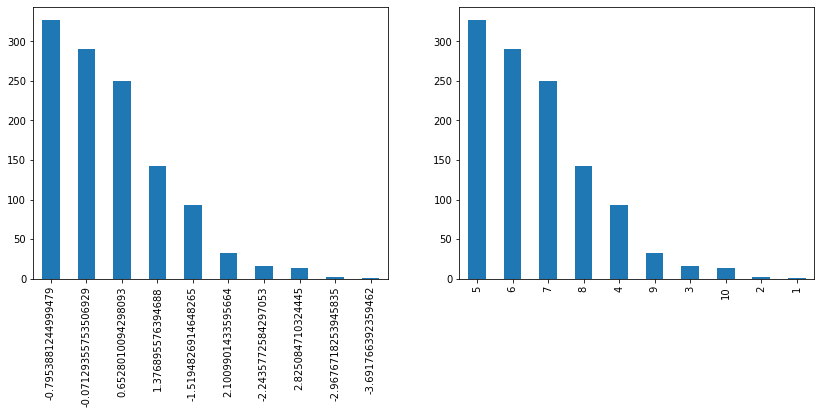

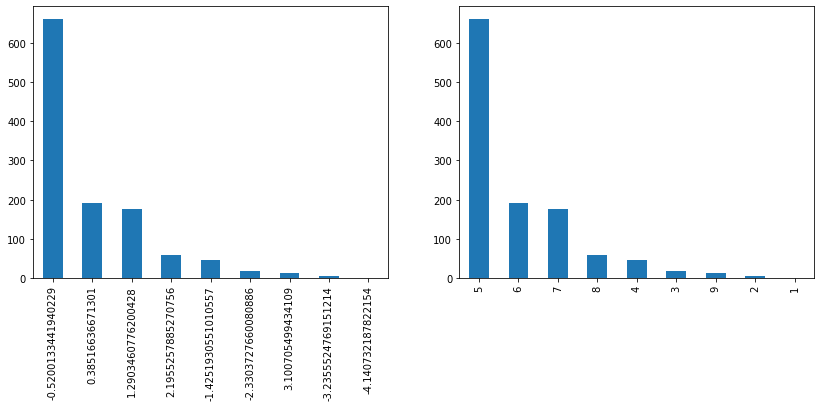

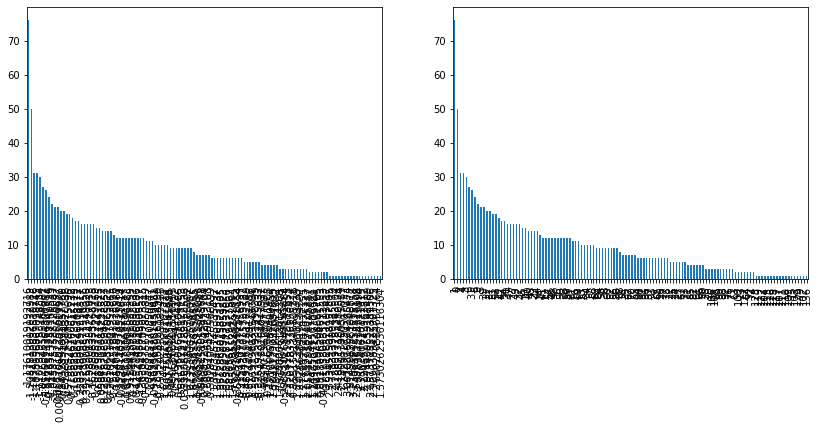

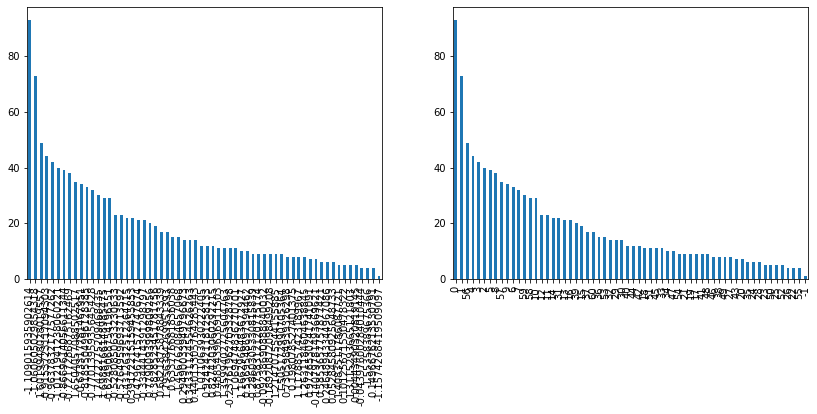

In [48]:
for i in range(len(cat_ord_cols)):
    fig = plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    cat_ord_clean_train[cat_ord_cols[i]].value_counts().plot.bar(ax=ax1)
    train[cat_ord_cols[i]].value_counts().plot.bar(ax=ax2)

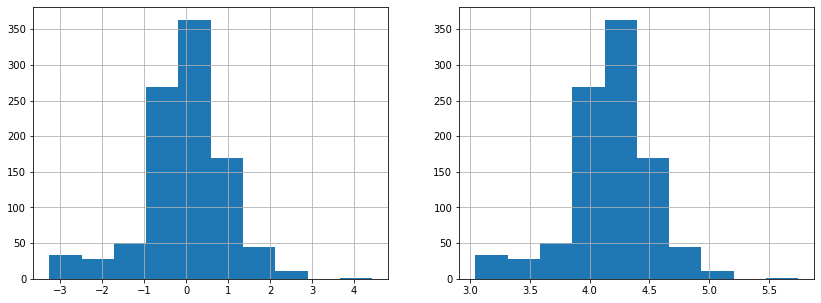

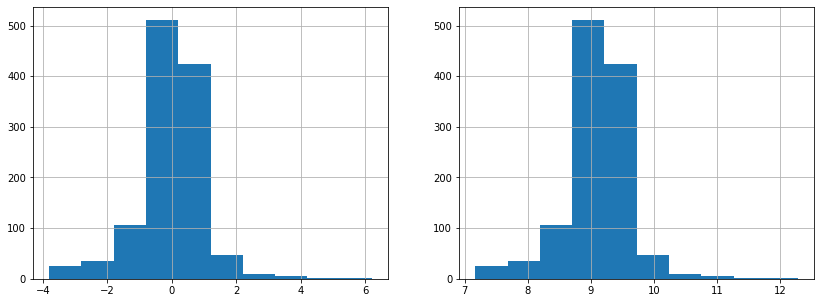

In [50]:
for i in range(len(num_cols)):
    fig = plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    num_clean_train[num_cols[i]].hist(ax=ax1)
    train[num_cols[i]].hist(ax=ax2)

In [54]:
X_train_A = pd.read_csv('../data/model_train_Alex.csv',index_col='Id')
X_test_A = pd.read_csv('../data/model_test_Alex.csv',index_col='Id')
X_Ktest_A = pd.read_csv('../data/kaggle_test_Alex.csv',index_col='Id')


In [55]:
cat_nom_cols_A = ['GarageType','GarageFinish','PavedDrive','Fence','MiscFeature',
                 'MoSold','SaleType','SaleCondition',]

In [58]:
for i in range(len(cat_nom_cols_A)):
    print(train[[cat_nom_cols_A[i]]].apply(lambda col: col.value_counts(),axis=0))
    print('-'*60)
    features = [col for col in X_train_A.columns if cat_nom_cols_A[i] in col]
    if features:
        print(X_train_A[features].apply(lambda col: col.value_counts(),axis=0))
    print('*'*60)

         GarageType
Attchd          685
Detchd          318
BuiltIn          74
Basment          15
CarPort           7
2Types            4
------------------------------------------------------------
     GarageType_2Types  GarageType_Basment  GarageType_BuiltIn  \
0.0               1164                1153                1094   
1.0                  4                  15                  74   

     GarageType_CarPort  GarageType_Detchd  GarageType_NoGarage  
0.0                1161                850                 1103  
1.0                   7                318                   65  
************************************************************
     GarageFinish
Unf           495
RFn           327
Fin           281
------------------------------------------------------------
     GarageFinish_Fin  GarageFinish_NoFinish  GarageFinish_RFn
0.0               887                   1103               841
1.0               281                     65               327
*******************

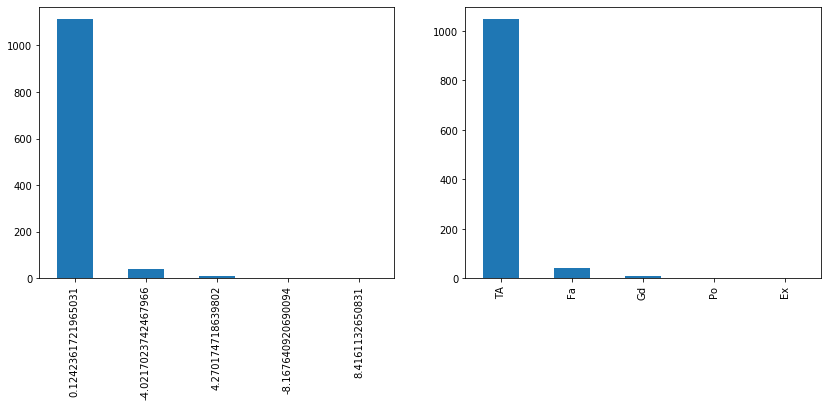

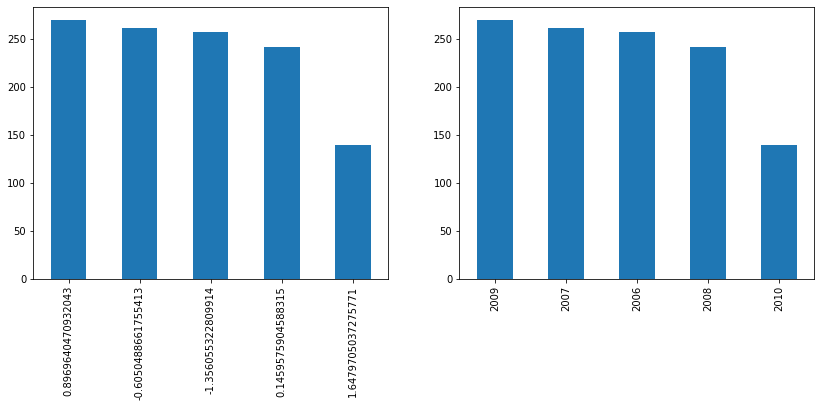

In [63]:
cat_ord_cols_A = ['GarageQual','YrSold']
for i in range(len(cat_ord_cols_A)):
    fig = plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    X_train_A[cat_ord_cols_A[i]].value_counts().plot.bar(ax=ax1)
    train[cat_ord_cols_A[i]].value_counts().plot.bar(ax=ax2)

KeyError: 'GarageAge'

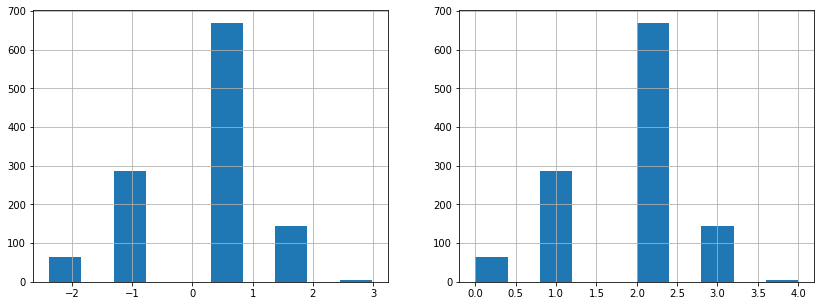

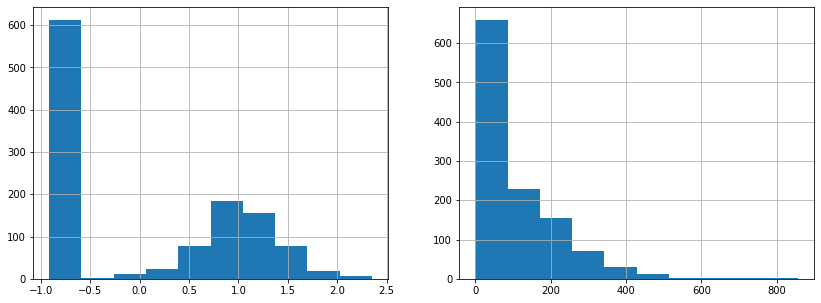

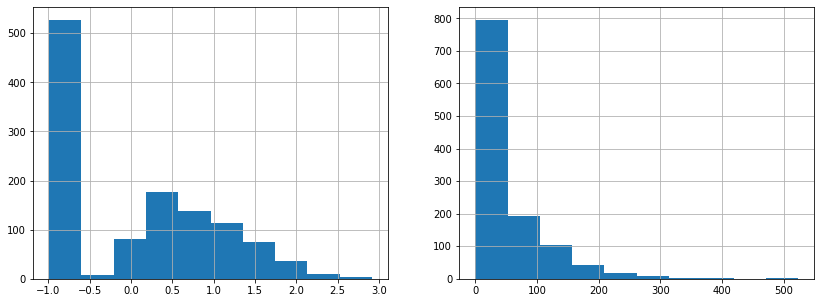

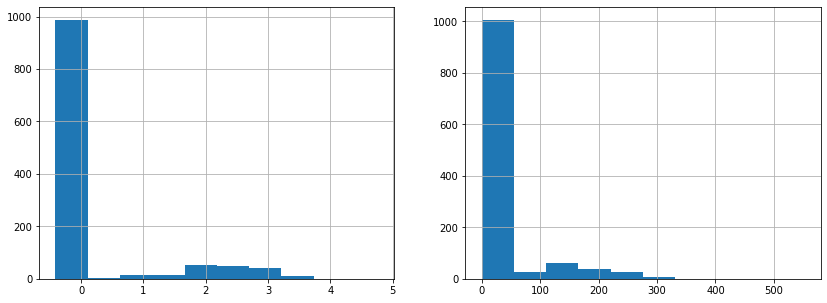

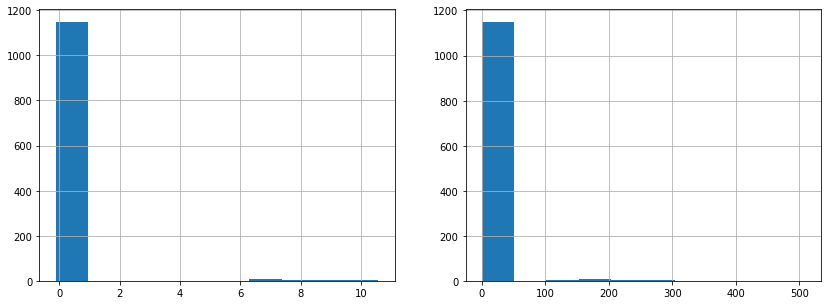

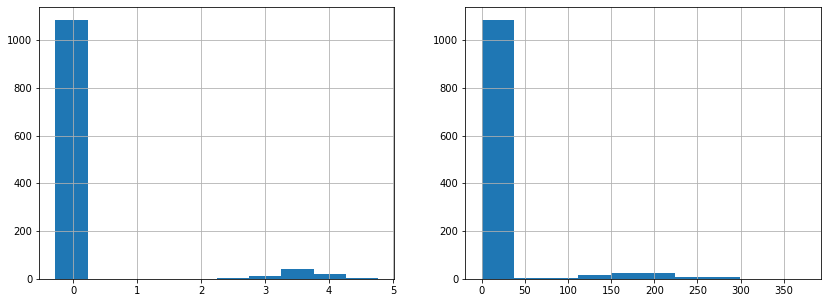

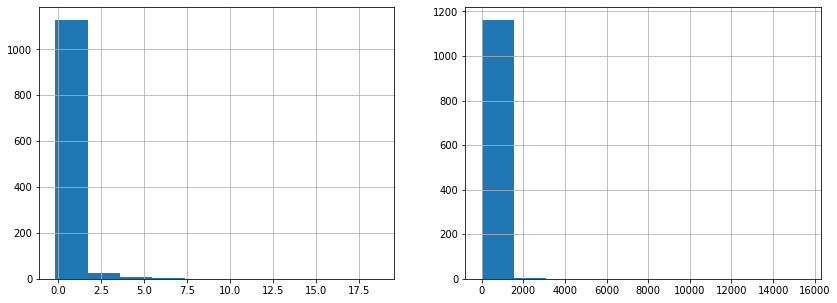

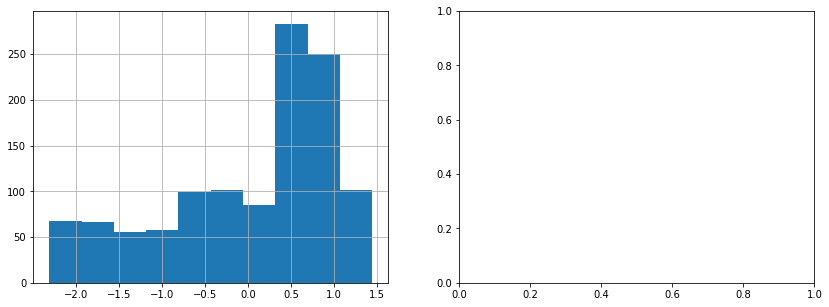

In [64]:
num_cols_A = ['GarageCars','WoodDeckSF','OpenPorchSF','EnclosedPorch',
             '3SsnPorch','ScreenPorch','MiscVal','GarageAge',]
for i in range(len(num_cols_A)):
    fig = plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    X_train_A[num_cols_A[i]].hist(ax=ax1)
    train[num_cols_A[i]].hist(ax=ax2)

In [62]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive